# Emotion Classification with BERT

In this project im going to build a multi-label emotion classifier using a pre-trained BERT model.

Im going to use:
- The GoEmotions dataset (1,000 text samples)
- The `bert-base-uncased` model from Hugging Face
- Tokenization and training using the Transformers library
- Multi-label setup with sigmoid activation and BCEWithLogitsLoss
- Evaluation using F1 score and classification report


# Importing the libraries

In [3]:
# load dataset and BERT
from datasets import load_dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoModelForSequenceClassification
)

# torch
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset

# data tools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score
)
from scipy.special import expit

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# system
import os
import random


#  Loading the GoEmotions Dataset

In [5]:
# Load a subset of the GoEmotions dataset (1,000 samples for speed)
dataset = load_dataset("go_emotions", "raw", split="train[:7000]")

# Convert to DataFrame
df = pd.DataFrame(dataset)
print("Dataset preview:")
print(df.head())


Dataset preview:
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_id  \
0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.548381e+09         1                 False           0  ...     0   
1  1.548084e+09        

# 3: emotion label list

In [7]:
# Define emotion columns

emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
    'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
    'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]
# This list is used to build binary label columns and define model output size


# 4: Clean data

In [9]:
# remove rows with empty or missing text
df = df[df['text'].notnull() & df['text'].str.strip().ne('')]
df = df.reset_index(drop=True)

# 5: Create binary label columns

In [11]:
# Convert list-style emotion annotations into binary columns (multi-label format)
# Each row can have more than one active emotion

has_emotion_columns = any(col in emotion_labels for col in df.columns)

# Turn list of emotions into binary columns (0 or 1)
# and if if the emotions columns do not already exist, create them
if not has_emotion_columns:
    print("Creating emotion label columns...")
    if 'emotions' in df.columns:
        for label in emotion_labels:
            df[label] = 0
        for idx, row in df.iterrows():
            if 'emotions' in row and isinstance(row['emotions'], list):
                for emotion_idx in row['emotions']:
                    if 0 <= emotion_idx < len(emotion_labels):
                        df.at[idx, emotion_labels[emotion_idx]] = 1
    else:
        print("Warning: No emotion columns or 'emotions' list found.")

# create a text version of active labels
df['emotions_text'] = df[emotion_labels].apply(
    lambda row: [label for label in emotion_labels if row[label] == 1],
    axis=1
)

#and lastly we print the summary
print("Dataset statistics:")
print(f"Number of samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")



Dataset statistics:
Number of samples: 7000
Columns: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'emotions_text']


# 6: Explore label counts

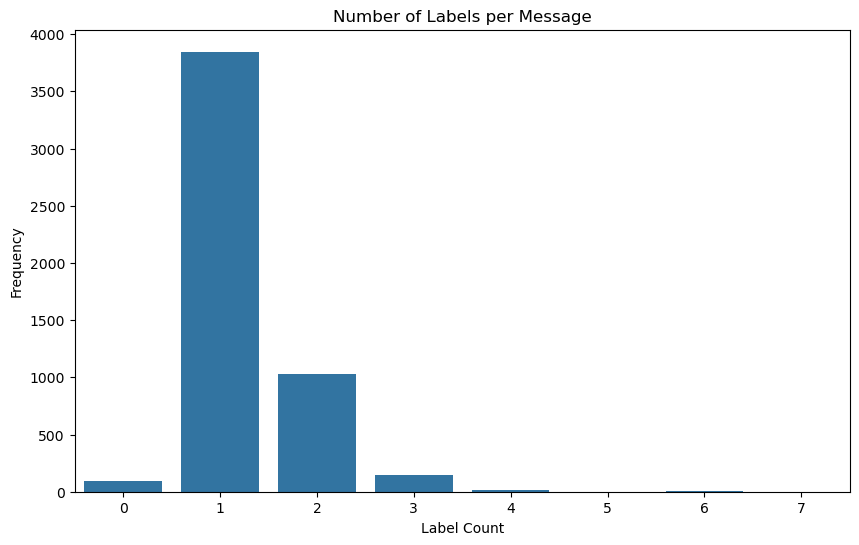

In [13]:
#Remove 'neutral' and calculate label counts

df = df[df["neutral"] != 1].reset_index(drop=True)

# Calculate label count after removing 'neutral'
df['label_count'] = df[emotion_labels].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.countplot(x='label_count', data=df)
plt.title("Number of Labels per Message")
plt.xlabel("Label Count")
plt.ylabel("Frequency")
plt.show()


# 7: Clean and filter data

In [15]:
# this step allow us to filter rows with no labels
df = df[df['label_count'] > 0]
df = df.reset_index(drop=True)

print(f"Remaining samples: {df.shape[0]}")


Remaining samples: 5043


# 8: Split train/test

In [17]:
# Split text and binary labels into training and testing sets (80/20 split)
X = df['text']
Y = df[emotion_labels]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 4034
Test size: 1009


# 9: Tokenize

In [19]:
# Tokenize text using BERT tokenizer

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

X_train_enc = tokenizer(
    list(X_train), truncation=True, padding=True, max_length=128, return_tensors="pt"
)

X_test_enc = tokenizer(
    list(X_test), truncation=True, padding=True, max_length=128, return_tensors="pt"
)
print(tokenizer)


BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


# 10: PyTorch dataset class

In [21]:
# Custom dataset to use with trainer
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings     # tokenized input
        self.labels = labels.values.tolist()       # labels as list

    def __getitem__(self, idx):
        # now we get item from encodings
        item = {key: val[idx] for key, val in self.encodings.items()}
         # then we add label
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)
        
# create train/test datasets
train_dataset = EmotionDataset(X_train_enc, Y_train)
test_dataset = EmotionDataset(X_test_enc, Y_test)


# 11: Load model

In [23]:
# Load BERT for multi-label classification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 12: Training setup

In [25]:
# first we setup training parameters
training_args = TrainingArguments(
    output_dir="./results",  # saveing the model
    num_train_epochs=6,    # this shows how many times to loop through the data
    per_device_train_batch_size=16, #this the amount of samples to use per step
    per_device_eval_batch_size=64, # the bigger the batch, the faster is the evaluation
    logging_dir="./logs",
    logging_steps=10,
    do_eval=True,   # run eval each epoch
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"  # choose best model by f1 macro score
)


# 13: Metrics + Trainer

In [27]:
# in this step we calculate f1 scores
def compute_metrics(pred):
    probs = torch.sigmoid(torch.tensor(pred.predictions)).numpy()  # get probabilities
    preds = (probs > 0.5).astype(int)
    labels = pred.label_ids
    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

# now create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# 14: Train

In [29]:
# Train model
trainer.train()


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.162500,0.162869,0.007812,0.004521
2,0.150700,0.145224,0.147143,0.064072
3,0.124700,0.136696,0.195089,0.092707
4,0.115800,0.136806,0.260012,0.126702
5,0.103000,0.135658,0.312791,0.167460
6,0.091900,0.136080,0.317768,0.172520


C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\anac

TrainOutput(global_step=1518, training_loss=0.1324786194385433, metrics={'train_runtime': 188.6695, 'train_samples_per_second': 128.288, 'train_steps_per_second': 8.046, 'total_flos': 622053381988800.0, 'train_loss': 0.1324786194385433, 'epoch': 6.0})

# 15: Evaluate

In [31]:
# Step 12: Evaluate
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)


Evaluation Results:
{'eval_loss': 0.1360796093940735, 'eval_f1_micro': 0.31776765375854216, 'eval_f1_macro': 0.17251991152567253, 'eval_runtime': 1.4212, 'eval_samples_per_second': 709.987, 'eval_steps_per_second': 11.258, 'epoch': 6.0}


C:\Users\moham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
# Save trained model and tokenizer
model.save_pretrained("emotion_model")
tokenizer.save_pretrained("emotion_model")


('emotion_model\\tokenizer_config.json',
 'emotion_model\\special_tokens_map.json',
 'emotion_model\\vocab.txt',
 'emotion_model\\added_tokens.json',
 'emotion_model\\tokenizer.json')

# 16: Predict new sample

In [40]:
# we run model on a new text and get top k predicted emotions
def predict_emotions(text, top_k=3):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=128
    )

    with torch.no_grad():
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(**inputs)

    # move from CUDA to CPU before converting to numpy
    probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
    top_indices = probs.argsort()[-top_k:][::-1]
    return [(emotion_labels[i], float(probs[i])) for i in top_indices]

# test it by using this example
text = "I'm happy to see my friends again!"
print(predict_emotions(text))


[('joy', 0.4985284209251404), ('excitement', 0.12504956126213074), ('admiration', 0.0661490187048912)]


# 17: Debug

In [43]:
# quick check to see dataset structure, column names and sample rows

print("\nDebug Info:")
print(f"Dataset structure: {type(dataset)}")
print(f"Columns: {df.columns.tolist()}")
print(df[['text'] + emotion_labels[:3]].head())



Debug Info:
Dataset structure: <class 'datasets.arrow_dataset.Dataset'>
Columns: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'emotions_text', 'label_count']
                                                text  admiration  amusement  \
0                                    That game hurt.           0          0   
1                                 Man I love reddit.           0          0   
2  Right? Considering it’s such an important docu...           0          0   
3  He isn't as big, but he's still quite popular....           0          0   
4  That's crazy; I went to a super [RELIGION]

In [51]:
!pip install gradio


   ---------------------------------------- 0.0/54.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/54.1 MB 3.4 MB/s eta 0:00:16
    --------------------------------------- 1.0/54.1 MB 2.4 MB/s eta 0:00:23
   - -------------------------------------- 1.6/54.1 MB 2.8 MB/s eta 0:00:19
   - -------------------------------------- 2.6/54.1 MB 3.3 MB/s eta 0:00:16
   -- ------------------------------------- 2.9/54.1 MB 2.8 MB/s eta 0:00:19
   -- ------------------------------------- 3.9/54.1 MB 3.2 MB/s eta 0:00:16
   --- ------------------------------------ 4.7/54.1 MB 3.3 MB/s eta 0:00:15
   ---- ----------------------------------- 5.5/54.1 MB 3.5 MB/s eta 0:00:15
   ---- ----------------------------------- 6.3/54.1 MB 3.4 MB/s eta 0:00:14
   ----- ---------------------------------- 6.8/54.1 MB 3.4 MB/s eta 0:00:14
   ----- ---------------------------------- 7.6/54.1 MB 3.4 MB/s eta 0:00:14
   ------ --------------------------------- 8.4/54.1 MB 3.4 MB/s eta 0:00:14
   ---

In [55]:
# Import Gradio library
import gradio as gr

# Create a simple web interface for the emotion prediction function
gr.Interface(
    fn=predict_emotions,  # the function we already defined for predictions
    inputs=gr.Textbox(lines=2, placeholder="Type a sentence here..."),  # input field for user text
    outputs="text",  # output will be shown as text labels
    title="Emotion Classifier",  # title shown at the top of the interface
    description="Enter a sentence and get the top predicted emotions from BERT."  # short user instruction
).launch()  # start the interface locally in your browser


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# This notebook implements a multi-label text classification pipeline using the GoEmotions dataset.

# Key design choices:

- **Subset of 7000 samples**: Speeds up training while preserving label diversity.
- **Removed 'neutral' class**: It lacks clear emotional signal and can bias learning.
- **Binary label matrix**: Required for multi-label classification with BERT.
- **Used `bert-base-uncased`**: A general-purpose pretrained model suitable for emotion detection.
- **Training setup**:
  - `num_train_epochs=6`: Balances training time and performance.
  - `per_device_train_batch_size=16`: Fits standard GPU memory limits.
  - Evaluation and saving per epoch ensures best model selection.
- **F1 Macro as best model metric**: Fair across imbalanced emotion classes.
- **Trainer API**: Simplifies training, logging, and evaluation.
- **Prediction function**: Supports top-k label output for inference.

This pipeline can be easily scaled up with more data or adapted to other multi-label NLP tasks.


# Gradio:
To make the model easier to test, I added a Gradio interface.
It creates a simple web app where you type a sentence and get the top predicted emotions.

This helped me:

* Check if the model responds reasonably to unseen examples

* Catch edge cases like sarcasm or ambiguous tone

* Present a cleaner demo without running code cells

Gradio made the project more interactive and user-friendly.
It also shows how the model could be deployed in a real product later.